# Implementation of clustering algorithms

Build K-Means and Agglomerative Clustering models to perform an unsupervised clustering by using given data. Follow below steps as a guideline for building your model and explain each of them in code lines. 

* Data cleaning (25 points)

Start with data cleaning to ensure that your data is correct, consistent and usable. The techniques used for data cleaning may vary but you can consider to follow these basic steps: handling missing values, encoding categorical features, extracting useful features by using existing features, handling outliers etc.

* Data Preprocessing (25 points)

In this step you should transform raw data into an understandable format for machine learning algorithms. This step may include scaling the features, performing dimensionality reduction etc.

* Clustering (30)

The goal of this step is to find distinct groups or “clusters” within a data set by using K-Means and Agglomerative Clustering Algorithms. Apply Elbow Method to determine the number of clusters. After building models, examine and comment the clusters formed via scatter plot.

* Silhouette Scores (20)

To evaluate how “well clustered” data points are, use the “silhouette score” and plot the Silhouette Scores for all of data points.

Note: Don't forget to explain your codes and comment on the obtained result.

In [1]:
#Importing necessary modules

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import mean
from numpy import std
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import cdist
%matplotlib inline
import seaborn as sns
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Reading the data file
df = pd.read_csv('data.csv')

In [4]:
#Changing categorical variables with numbers

In [5]:
df['Marital_Status'].replace(['Single', 'Together','Married','Divorced','Widow','Alone'],
                        [0, 1,2,3,4,6], inplace=True)
df['Education'].replace(['Graduation', 'PhD','Master','2n Cycle','Basic'],
                        [0,1,2,3,4], inplace=True)
# Since single and alone mean the same, the two columns have been combined to get more accurate results.

In [6]:
print("Number of unique id's in CUST_ID column : ",df.ID.nunique())
print("Number of rows in dataframe : ",df.shape[0])
#This is to check if we have a single row for each unique ID. We can drop id since we do not get any information from it.

Number of unique id's in CUST_ID column :  1001
Number of rows in dataframe :  1001


In [7]:
df.drop_duplicates()
df = df.drop(columns=['Unnamed: 0','ID','Dt_Customer','Z_CostContact','Z_Revenue'])
df['Income'] = round(df['Income'].fillna(df['Income'].median()))

# Dropping duplicatates, dropping unnecessary colums and fill the NaN values in income column
#Unnamed: 0, ID columns dropped because we do not get any information from them,they only show the order of rows.
#Dt_customer is also an unnecesarry column,this field does not help clustering to summarize customer segments.

In [8]:
df.style

In [9]:
#Handling outliers
#Handling outliers is very necessary step for data cleaning.Because The outliers that will prevent us from doing the right clustering of the data set have been removed.
#Rows became more understandable with decreasing number of rows
z_scores = np.abs(stats.zscore(df, nan_policy='omit'))
outliers_threshold = 3  # 3 means that 99.7% of the data is saved to get more smooth data, we can set 2 or 1 for this value
mask = (z_scores <= outliers_threshold).all(axis=1)
df = df[mask]

In [10]:
df.shape

(724, 25)

In [11]:
# There are many steps for data cleaning. Considering the result we want to achieve, the data that may prevent us from reaching the correct result are cleared from the data set.

# Data Preprocessing

In [12]:
#Standardizing a dataset involves rescaling the distribution of values such that the mean of the observed values is 0 and the standard deviation is 1.
#Scaling should be made for clustering,otherwise it will be very difficult to understand the data set 
scaler = StandardScaler()
Scaled_df = scaler.fit_transform(df)

df_scaled = pd.DataFrame(Scaled_df,columns=df.columns)
df_scaled.head()


Year_Birth  Education  Marital_Status    Income   Kidhome  Teenhome  \
0   -1.084612  -0.833968       -1.445160  0.589005 -0.919268 -0.956436   
1   -1.347857  -0.833968       -1.445160 -0.053036  0.809434  0.832866   
2   -0.382626  -0.833968       -0.496569  1.322557 -0.919268 -0.956436   
3    1.284591  -0.833968       -0.496569 -1.125356  0.809434 -0.956436   
4    1.021346   0.068562        0.452022  0.597443  0.809434 -0.956436   

    Recency  MntWines  MntFruits  MntMeatProducts  ...  NumCatalogPurchases  \
0  0.263536  1.552435   2.398995         2.610342  ...             3.236660   
1 -0.430661 -0.784115  -0.606094        -0.673046  ...            -0.430542   
2 -0.847179  0.769840   1.051886         0.062676  ...            -0.023075   
3 -0.847179 -0.784115  -0.502470        -0.587921  ...            -0.838008   
4  1.513090 -0.177511   0.844639         0.007953  ...             0.384392   

   NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0          -0.472932           0.703108           0.0           0.0   
1          -1.101194          -0.236966           0.0           0.0   
2           1.411854          -0.707003           0.0           0.0   
3          -0.472932           0.233071           0.0           0.0   
4           0.155330          -0.236966           0.0           0.0   

   AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0           0.0           0.0           0.0       0.0  3.979599  
1           0.0           0.0           0.0       0.0 -0.251282  
2           0.0           0.0           0.0       0.0 -0.251282  
3           0.0           0.0           0.0       0.0 -0.251282  
4           0.0           0.0           0.0       0.0 -0.251282  

[5 rows x 25 columns]

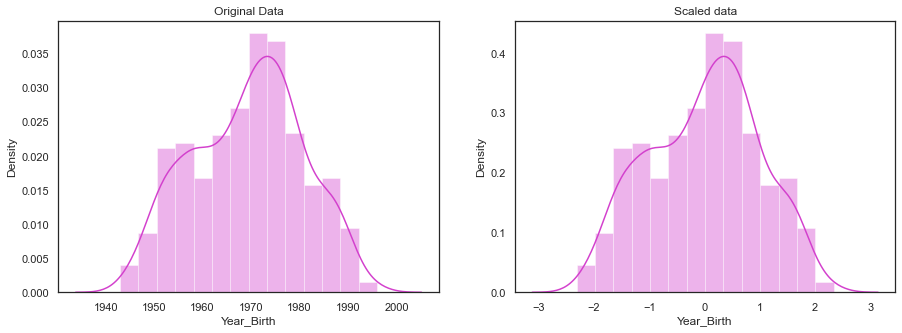

In [13]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(df['Year_Birth'], ax=ax[0],color='#D341CD')
ax[0].set_title("Original Data")
sns.distplot(df_scaled['Year_Birth'], ax=ax[1],color='#D341CD')
ax[1].set_title("Scaled data")
plt.show()

In [14]:
#KMeans Modelling

In [15]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Scaled_df)
    Sum_of_squared_distances.append(km.inertia_)

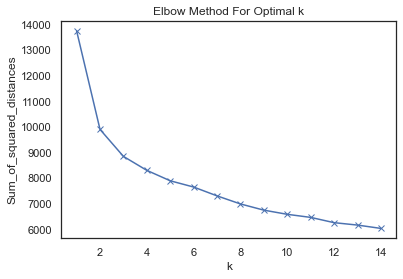

In [16]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# From the graph we can choose the optimal_k=2 with using Elbow Method(Actually it can be also 3 but from the silhouette score part we can see that k = 2)

In [17]:
kmeans = KMeans(n_clusters=2,random_state=0)
kmeans.fit(df_scaled)

KMeans(n_clusters=2, random_state=0)

In [18]:
#Below result shows how the data points are categorized into the two clusters.
kmeans.labels_

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,

In [19]:
#Silhouette Coefficient
from sklearn.metrics import silhouette_score, silhouette_samples
for n_clusters in range(2,21):
    km = KMeans (n_clusters=n_clusters)
    preds = km.fit_predict(Scaled_df)
    centers = km.cluster_centers_

    score = silhouette_score(Scaled_df, preds, metric='euclidean')
    print ("For n_clusters = {}, silhouette score is {}".format(n_clusters, score))
    
#The k value with the largest silhouette score value is equal to 2. Therefore, optimal_k should be chosen as 2.    

For n_clusters = 2, silhouette score is 0.2843130012231237
For n_clusters = 3, silhouette score is 0.20576336850169205
For n_clusters = 4, silhouette score is 0.12603959748050042
For n_clusters = 5, silhouette score is 0.13613151979366744
For n_clusters = 6, silhouette score is 0.1296052740686941
For n_clusters = 7, silhouette score is 0.11555586169705653
For n_clusters = 8, silhouette score is 0.1358318154598958
For n_clusters = 9, silhouette score is 0.1267902003797274
For n_clusters = 10, silhouette score is 0.12888305409975095
For n_clusters = 11, silhouette score is 0.12867419345409722
For n_clusters = 12, silhouette score is 0.1317005143441754
For n_clusters = 13, silhouette score is 0.12977979266656856
For n_clusters = 14, silhouette score is 0.10960079960924846
For n_clusters = 15, silhouette score is 0.11989584903180671
For n_clusters = 16, silhouette score is 0.10508240017950365
For n_clusters = 17, silhouette score is 0.12960692593654508
For n_clusters = 18, silhouette score

In [20]:
#pip install --user yellowbrick

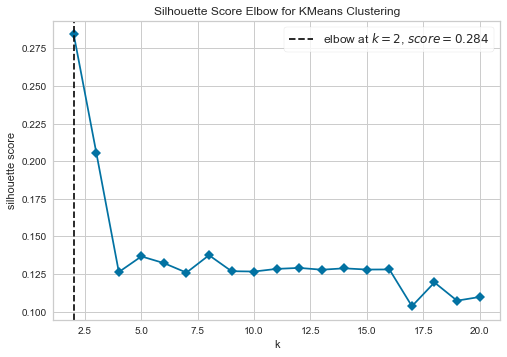

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
km = KMeans (n_clusters=2)
visualizer = KElbowVisualizer(
    km, k=(2,21),metric ='silhouette', timings=False
)

visualizer.fit(Scaled_df) 
visualizer.poof() 

#By completing the yellowbrick download, we can also observe the Silhouette score elbow for KMeans Clustering graph.

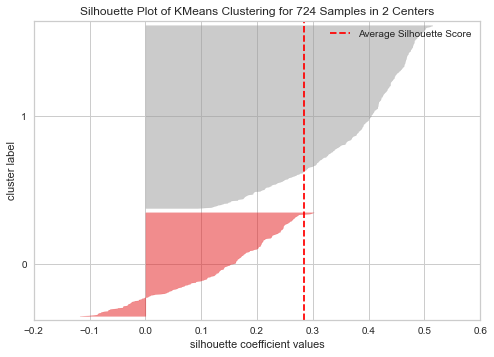

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 724 Samples in 2 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
from yellowbrick.cluster import SilhouetteVisualizer

# Instantiate the clustering model and visualizer
km = KMeans (n_clusters=2)
visualizer = SilhouetteVisualizer(km)

visualizer.fit(Scaled_df) # Fit the training data to the visualizer
visualizer.poof() 

In [23]:
#Results
km = KMeans(n_clusters=2)
km.fit(Scaled_df)

KMeans(n_clusters=2)

In [24]:
#KMEANS_LABELS TABLE FROM USING CLUSTER_LABEL
cluster_label = km.labels_
df['KMEANS_LABELS'] = cluster_label
df.head()

Year_Birth  Education  Marital_Status   Income  Kidhome  Teenhome  Recency  \
0        1957          0               0  58138.0        0         0       58   
1        1954          0               0  46344.0        1         1       38   
2        1965          0               1  71613.0        0         0       26   
3        1984          0               1  26646.0        1         0       26   
4        1981          1               2  58293.0        1         0       94   

   MntWines  MntFruits  MntMeatProducts  ...  NumStorePurchases  \
0       635         88              546  ...                  4   
1        11          1                6  ...                  2   
2       426         49              127  ...                 10   
3        11          4               20  ...                  4   
4       173         43              118  ...                  6   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0                  7             0             0             0             0   
1                  5             0             0             0             0   
2                  4             0             0             0             0   
3                  6             0             0             0             0   
4                  5             0             0             0             0   

   AcceptedCmp2  Complain  Response  KMEANS_LABELS  
0             0         0         1              1  
1             0         0         0              0  
2             0         0         0              1  
3             0         0         0              0  
4             0         0         0              0  

[5 rows x 26 columns]

In [25]:
df.columns

Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts',
       'MntFishProducts', 'MntSweetProducts', 'MntGoldProds',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'KMEANS_LABELS'],
      dtype='object')

In [26]:
#Create a spent column by collecting columns related to spent(MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts)
#Because it is necessary to use expenditures to summarize customer segments. That's why I combined all expenses in one column.
df['Spent'] = df['MntWines'] + df['MntFruits']+ df['MntMeatProducts']+df['MntFishProducts']+df['MntSweetProducts']
df['Spent']

0      1529
1        21
2       734
3        48
4       407
       ... 
993     735
994      88
995      19
997      69
999     293
Name: Spent, Length: 724, dtype: int64

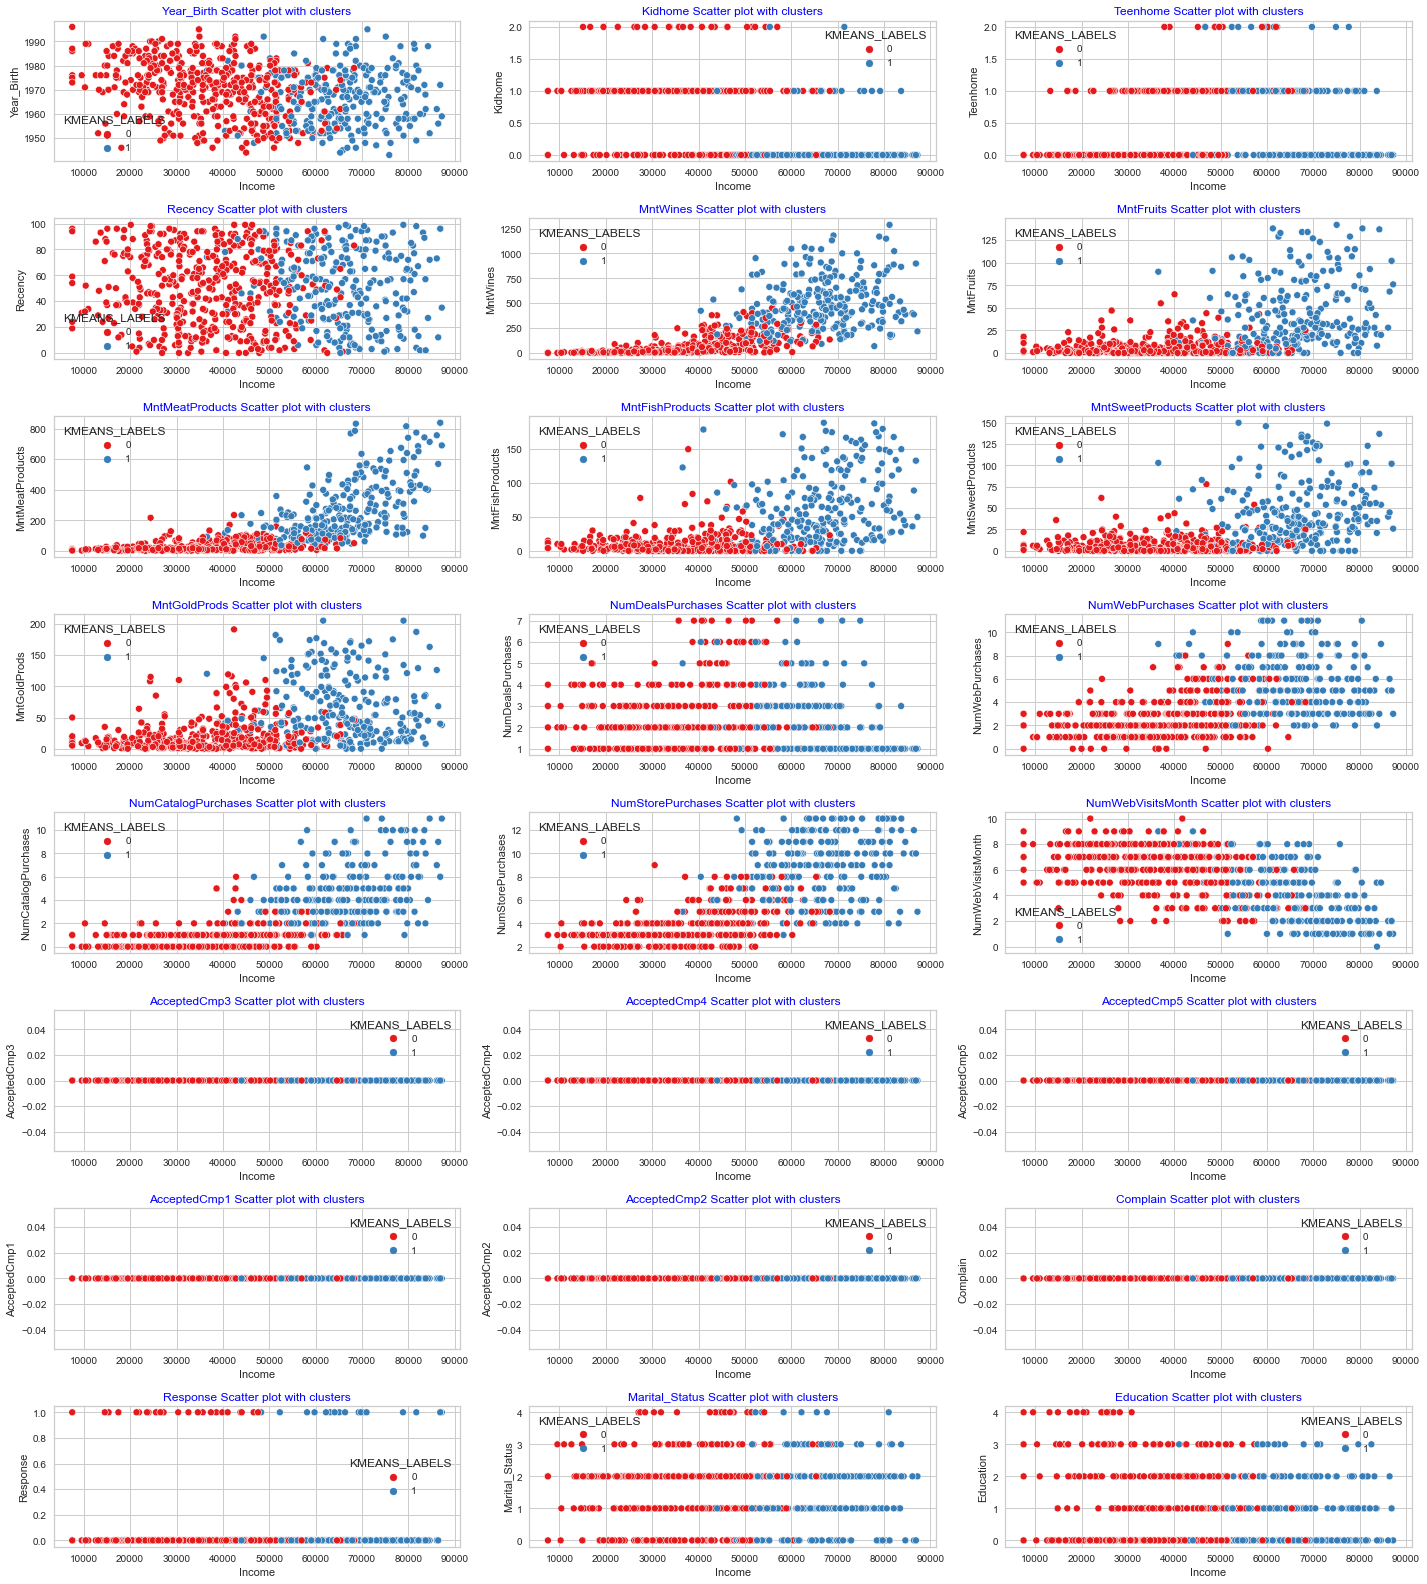

In [27]:
# K-means clustering is an extensively used technique for data cluster analysis.
f=plt.figure(figsize=(20,30))
scatter_cols =['Year_Birth', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Response',
       'Marital_Status','Education']
for i, col in enumerate(scatter_cols):
    ax=f.add_subplot(11,3,i+1)
    sns.scatterplot(x=df['Income'],y=df[col],hue=df['KMEANS_LABELS'],palette='Set1')
    ax.set_title(col+" Scatter plot with clusters",color='blue')
    plt.ylabel(col)
f.tight_layout()

In [28]:
# K Means on selected features
# Based on both the graphics and the given features, Income and MntGoldProds columns were used.
sample_df = pd.DataFrame([df['Spent'],df['Income']])
sample_df = sample_df.T
sample_df.head()

Spent   Income
0  1529.0  58138.0
1    21.0  46344.0
2   734.0  71613.0
3    48.0  26646.0
4   407.0  58293.0

In [29]:
#Standardization is useful for data which has negative values. It arranges the data in a standard normal distribution.
scaler = StandardScaler()
Sample_Scaled_df = scaler.fit_transform(sample_df)

In [30]:
# Using sampling for the AgglomerativeClustering
km_sample = KMeans(n_clusters=4)
km_sample.fit(Sample_Scaled_df)

KMeans(n_clusters=4)

In [31]:
labels_sample = km_sample.labels_
sample_df['label'] = labels_sample

<AxesSubplot:xlabel='Income', ylabel='Spent'>

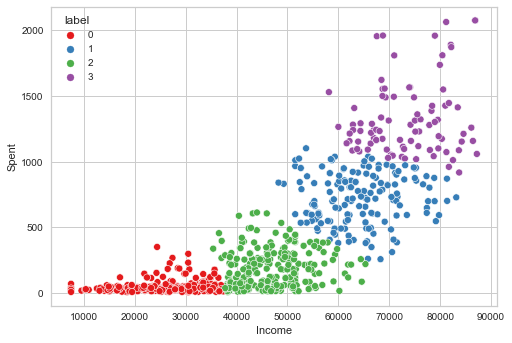

In [32]:
sns.set_palette('Set2')
sns.scatterplot(sample_df['Income'],sample_df['Spent'],hue=sample_df['label'],palette='Set1')

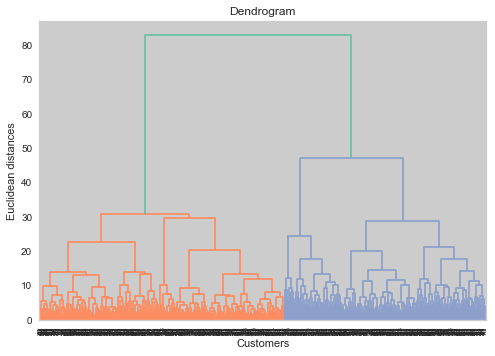

In [33]:
dendrogram = sch.dendrogram(sch.linkage(Scaled_df, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [34]:
#Using the dendrogram to find the optimal numbers of clusters.
#n should be 6 according the dendrogram.
model = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
model.fit_predict(Scaled_df)
labels = model.labels_
labels

array([0, 1, 0, 3, 3, 5, 2, 3, 4, 3, 1, 5, 3, 1, 1, 3, 1, 5, 5, 3, 1, 3,
       3, 1, 4, 0, 1, 5, 3, 1, 3, 1, 1, 3, 4, 3, 1, 2, 3, 5, 0, 3, 3, 5,
       5, 2, 5, 0, 4, 1, 2, 2, 0, 3, 2, 1, 3, 3, 3, 3, 1, 0, 1, 1, 1, 0,
       3, 3, 3, 1, 1, 1, 1, 0, 0, 3, 1, 2, 3, 2, 5, 1, 2, 1, 3, 5, 4, 3,
       3, 2, 1, 5, 5, 2, 2, 2, 5, 3, 1, 1, 0, 0, 5, 2, 5, 4, 5, 1, 5, 2,
       5, 5, 1, 1, 0, 1, 3, 2, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 3, 2, 3, 1,
       3, 1, 2, 0, 1, 0, 3, 5, 1, 2, 2, 1, 5, 1, 5, 0, 5, 1, 5, 2, 3, 0,
       5, 3, 2, 3, 2, 2, 0, 3, 3, 1, 2, 3, 3, 5, 3, 2, 3, 2, 1, 2, 0, 3,
       3, 1, 2, 3, 1, 1, 1, 5, 3, 3, 4, 1, 0, 3, 0, 5, 1, 1, 5, 0, 5, 3,
       2, 1, 5, 1, 3, 0, 1, 3, 3, 1, 3, 3, 0, 1, 5, 3, 3, 3, 4, 1, 3, 3,
       0, 5, 1, 1, 2, 1, 2, 3, 1, 2, 5, 2, 3, 3, 1, 3, 3, 3, 0, 3, 2, 3,
       0, 1, 5, 1, 1, 2, 0, 0, 5, 0, 5, 5, 3, 3, 5, 2, 0, 3, 5, 3, 5, 4,
       1, 3, 2, 3, 3, 3, 1, 5, 3, 3, 2, 1, 2, 1, 1, 5, 0, 1, 4, 3, 4, 1,
       0, 1, 1, 1, 4, 5, 3, 5, 4, 2, 2, 2, 0, 3, 3,

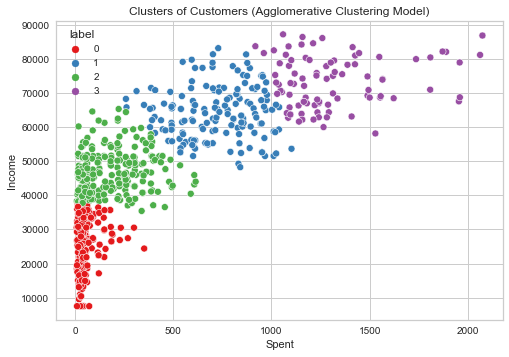

In [35]:
# Plotting the Agglomerative Clustering Model
sns.set_palette('Set2')
sns.scatterplot(sample_df['Spent'],sample_df['Income'],hue=sample_df['label'],palette='Set1')
plt.title('Clusters of Customers (Agglomerative Clustering Model)')
plt.show()